# Model Comparison Dashboard (Baseline Models)

LightGBM, XGBoost, CatBoost, Random Forest, Logistic Regression 모델의 시험 결과를 한 눈에 비교하고 상위 피처 중요도를 교차 분석합니다.


## 1. 환경 설정


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")


## 2. 모델별 평가지표 요약

각 summary 노트북에서 계산된 시험(PR-AUC / Recall / Accuracy) 지표를 정리합니다.


In [ ]:

metrics_data = [
    {"model": "LightGBM", "PR-AUC": 0.9339, "Recall": 0.9019, "Accuracy": 0.9710},
    {"model": "XGBoost", "PR-AUC": 0.9356, "Recall": 0.8467, "Accuracy": 0.9752},
    {"model": "CatBoost", "PR-AUC": 0.9339, "Recall": 0.9347, "Accuracy": 0.9580},
    {"model": "RandomForest", "PR-AUC": 0.9236, "Recall": 0.8114, "Accuracy": 0.9729},
    {"model": "LogisticRegression", "PR-AUC": 0.8379, "Recall": 0.9074, "Accuracy": 0.9342},
]

metrics_df = pd.DataFrame(metrics_data)
metrics_df.sort_values("PR-AUC", ascending=False, inplace=True)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df


,model,PR-AUC,Recall,Accuracy
0,XGBoost,0.9356,0.8467,0.9752
1,LightGBM,0.9339,0.9019,0.9710
2,CatBoost,0.9339,0.9347,0.9580
3,RandomForest,0.9236,0.8114,0.9729
4,LogisticRegression,0.8379,0.9074,0.9342


/var/folders/n6/9fr973913k7931ymsg4ly6rc0000gn/T/ipykernel_10344/1788689261.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=metrics_df, x="model", y="PR-AUC", palette="viridis")


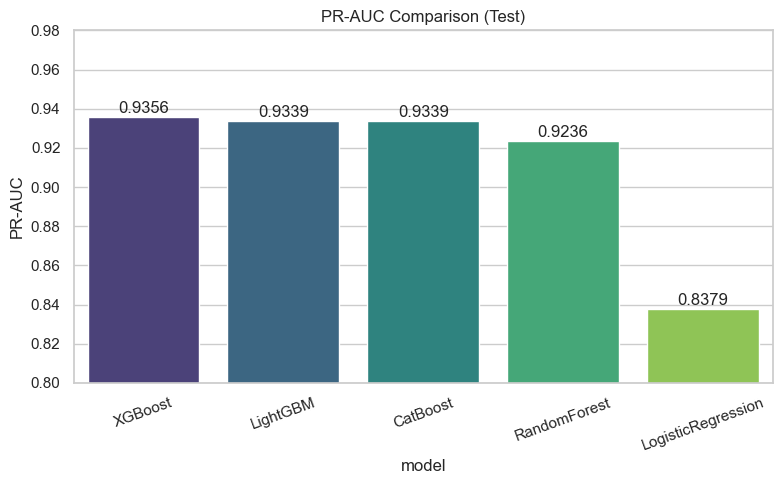

In [ ]:

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=metrics_df, x="model", y="PR-AUC", palette="viridis")
ax.set_ylim(0.8, 0.98)
ax.set_title("PR-AUC Comparison (Test)")
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height()+0.002, f"{p.get_height():.4f}", ha="center")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


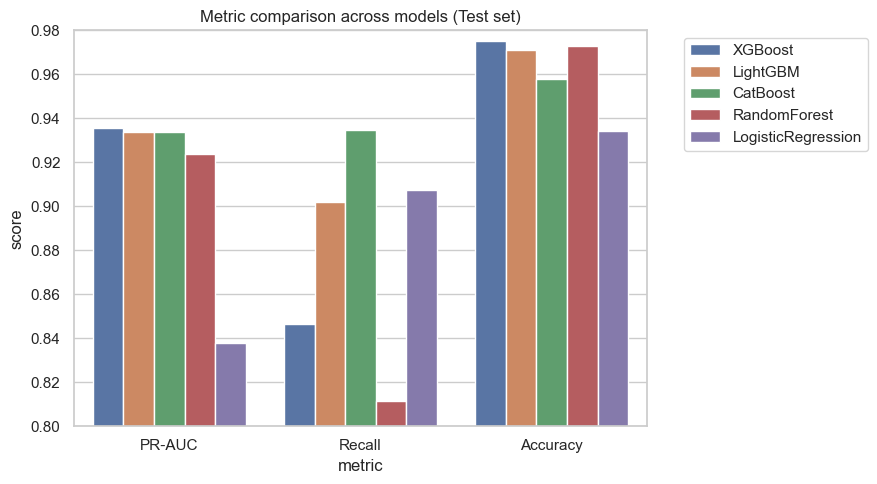

In [ ]:

metrics_long = metrics_df.melt(id_vars="model", value_vars=["PR-AUC", "Recall", "Accuracy"], var_name="metric", value_name="score")
plt.figure(figsize=(9,5))
sns.barplot(data=metrics_long, x="metric", y="score", hue="model")
plt.ylim(0.8, 0.98)
plt.title("Metric comparison across models (Test set)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 관찰 포인트

- PR-AUC 기준으로는 XGBoost와 LightGBM, CatBoost가 박빙이며, RandomForest가 그 뒤를 따릅니다.
- Recall은 CatBoost가 가장 높고, Logistic Regression이 그 뒤를 이어 churn 민감도 측면에서 강점을 보입니다.
- Accuracy는 XGBoost와 RandomForest가 근소하게 높습니다.


## 3. Feature Importance 교차 비교

각 모델별 feature importance CSV를 로드하여 상위 20개 피처의 normalized importance를 비교합니다.


In [ ]:

importance_map = {
    "LightGBM": {"path": "../data/model_df/lgb_feature_importance.csv", "column": "importance", "transform": lambda df: df},
    "XGBoost": {"path": "../data/model_df/xgb_feature_importance.csv", "column": "importance", "transform": lambda df: df},
    "CatBoost": {"path": "../data/model_df/catboost_feature_importance.csv", "column": "importance", "transform": lambda df: df},
    "RandomForest": {"path": "../data/model_df/rf_feature_importance.csv", "column": "importance", "transform": lambda df: df},
    "LogisticRegression": {"path": "../data/model_df/lr_feature_importance.csv", "column": "abs_coef", "transform": lambda df: df.assign(abs_coef=df["coef"].abs())},
}

def load_top_features(model, top_n=20):
    info = importance_map[model]
    df = pd.read_csv(info["path"])
    df = info["transform"](df)
    col = info["column"]
    if col not in df.columns:
        raise ValueError(f"{model} 파일에서 '{col}' 컬럼을 찾을 수 없습니다.")
    df = df[["feature", col]].rename(columns={col: "importance"})
    df = df.sort_values("importance", ascending=False).head(top_n)
    df["importance_norm"] = df["importance"] / df["importance"].sum()
    df["model"] = model
    return df

frames = [load_top_features(m) for m in importance_map.keys()]
importance_df = pd.concat(frames, ignore_index=True)
importance_df.head()


,feature,importance,importance_norm,model
0,reg_days,8650.0,0.108709,LightGBM
1,days_since_last_payment,7392.0,0.092899,LightGBM
2,completion_trend_w7_w30,4533.0,0.056969,LightGBM
3,city,4299.0,0.054028,LightGBM
4,variety_ratio_w30,4277.0,0.053751,LightGBM


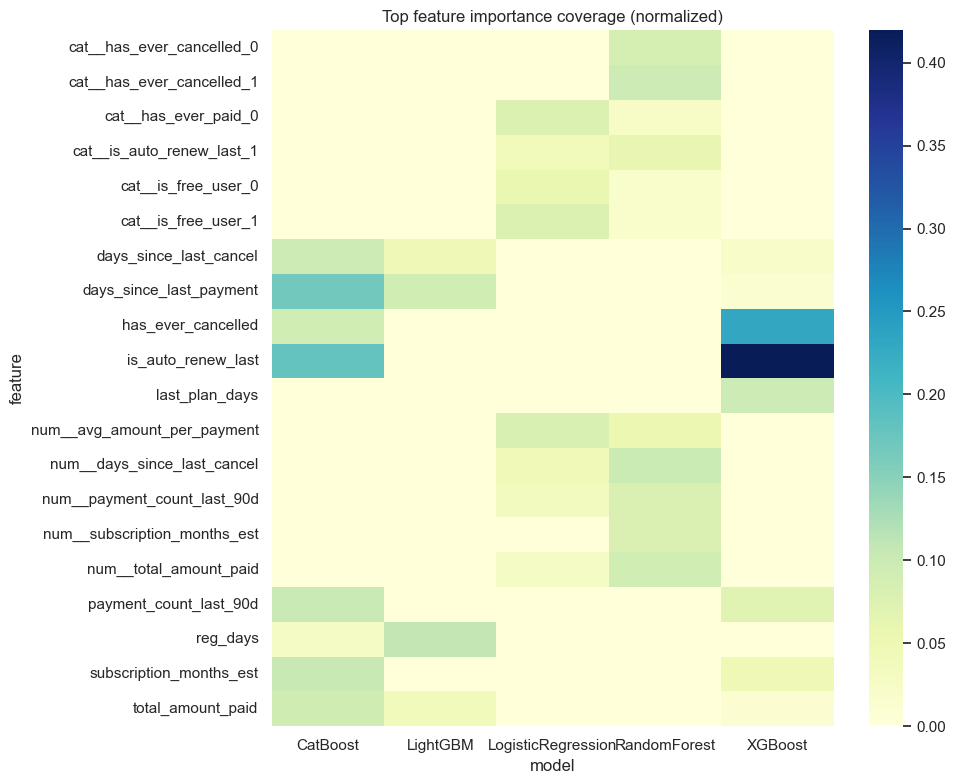

In [ ]:

top_features = (
    importance_df.groupby("feature")["importance_norm"].sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

pivot_df = (
    importance_df[importance_df["feature"].isin(top_features)]
    .pivot(index="feature", columns="model", values="importance_norm")
    .fillna(0)
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=False)
plt.title("Top feature importance coverage (normalized)")
plt.tight_layout()
plt.show()


### Feature Insight

- LightGBM / XGBoost / CatBoost는 시계열 usage duration 계열 피처에 높은 중요도를 부여하며, Logistic Regression은 coef 부호로 churn 증가/감소 방향까지 확인할 수 있습니다.
- RandomForest는 OHE 이후 희소 피처 분산으로 인해 중요도가 상대적으로 분산되어 있음을 Heatmap에서 확인할 수 있습니다.
- 동일한 피처가 여러 모델에서 상위권을 차지하면 행 색이 진해지며, 이는 공통 핵심 피처를 가리킵니다.


## 4. 요약

- **성능**: Gradient Boosting 계열(XGB, LGBM, CatBoost)이 전반적으로 우수하며, CatBoost는 Recall, XGB는 PR-AUC/Accuracy에서 강점.
- **피처**: 상위 피처는 `total_secs_*`, `num_days_active_*`, `variety_ratio` 등 사용 패턴 지표에 집중되어 있으며, Logistic Regression에서는 음/양의 영향력이 분명합니다.
- **활용**: 본 노트북은 baseline 비교용으로, 추가 튜닝 결과를 반영할 땐 metrics_data와 feature CSV만 업데이트하면 됩니다.
